def noise_generator(x, alpha):  
    noise = torch.normal(0, 1e-2, size=(len(x), 1))  
    noise[torch.randint(0, len(x), (int(len(x)*(1-alpha)),))] = 0  
    return noise  

> values = values + noise_generator(values, 0.3)
        
> loss = criterion(outputs, values) # 손실 함수 계산  

`(torch.Size([32, 1]),
 tensor([[ 0.0000],
         [ 0.0000],
         [-0.0133],
         [ 0.0000],
         [ 0.0000]]))`

In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./reg.csv', index_col=[0])
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333


In [5]:
X = df.drop('Price', axis=1).to_numpy() 
Y = df['Price'].to_numpy().reshape((-1,1))

In [6]:
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [8]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.5) # 연산이 될 때마다 50%의 비율로 랜덤하게 노드를 없앤다.
        
    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) 
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x)) 

        return x

In [9]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [10]:
def noise_generator(x, alpha):
    noise = torch.normal(0, 1e-2, size=(len(x), 1))
    noise[torch.randint(0, len(x), (int(len(x)*(1-alpha)),))] = 0

    return noise

In [13]:
noise_g = noise_generator(next(iter(trainloader))[1], 0.3)

In [19]:
noise_g.shape, noise_g[:5]

(torch.Size([32, 1]),
 tensor([[ 0.0000],
         [ 0.0000],
         [-0.0133],
         [ 0.0000],
         [ 0.0000]]))

In [20]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader)

for epoch in range(101): # 400번 학습을 진행한다.

    running_loss = 0.0

    for data in trainloader: # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.
       
        optimizer.zero_grad() # 최적화 초기화

        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        
        values = values + noise_generator(values, 0.3)
        
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트

        running_loss += loss.item() 

    loss_.append(running_loss/n)
    
    if epoch % 10 == 0:
        print(f"epoch : {epoch}")

epoch : 0
epoch : 10
epoch : 20
epoch : 30
epoch : 40
epoch : 50
epoch : 60
epoch : 70
epoch : 80
epoch : 90
epoch : 100


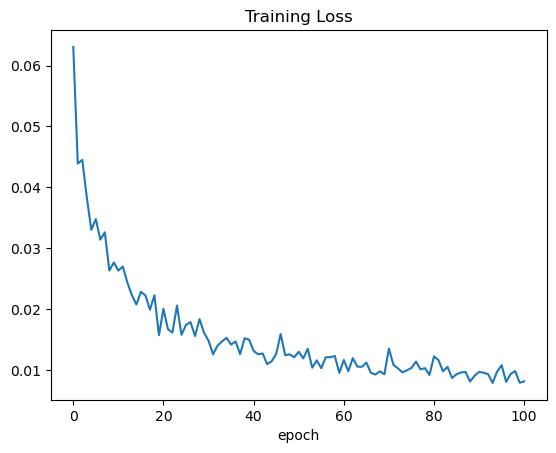

In [21]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [22]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서
        
    with torch.no_grad():
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat을 통해 예측값을 누적
            actual = torch.cat((actual, values), 0) # cat을 통해 실제값을 누적
    
    predictions = predictions.numpy() # 넘파이 배열로 변경
    actual = actual.numpy() # 넘파이 배열로 변경
    rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용하여 RMSE 계산
    
    return rmse  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [23]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

Train RMSE:  0.07695694
Test RMSE:  0.11862436
